# 67364 Final Project: Predicting Crime in US Cities
Tiffany Zhu and Justin Chan

## 1. Initial Question

We are interested in seeing if we can predict crime rates of cities in the US. We want to know what factors contribute to the crime rate, for example household income and demographic information.

## 2. The Data Set

Our data set can be found on the UCI Machine Learning Repository (http://archive.ics.uci.edu/ml/datasets/Communities+and+Crime+Unnormalize). The data contains information from 2215 different cities in the US. Each city has 147 attributes population demographics, income information, housing information and police information such as crime rates and the demographics of the police force. The demographic, income and housing information was from the 1990 Census and police information was taken from a 1995 Law Enforcement Survey. Additionally, as we will see below, several of the attributes contain NAs for most cities, so we have to initally remove several attributes.

Below, we grab the data set and don't include the features that contain NAs in most of the instances (cities).

In [1]:
import matplotlib.pyplot as plt
from pprint import pprint as pp
import numpy as np
import pandas as pd

feature_matrix = []
target_vector1 = []
target_vector2 = []
varToNumNA = dict()

for line in open('CommViolPredUnnormalizedData.txt', 'r'):
    features_orig = line.strip().split(',')
    for i in range(len(features_orig)):
        if features_orig[i] == '?':
            try:
                varToNumNA[i] += 1
            except:
                varToNumNA[i] = 1
    
    target1 = features_orig[-2] # ViolentCrimesPerPop
    target2 = features_orig[-1] # nonViolPerPop
    #features = [ f for f in features[3:-2]] # don't include town and state name
    features = [ f for f in features_orig[4:103] ] #don't include 103
    features += [f for f in features_orig[120:123]] #don't include 103-119, or 123
    features += [features_orig[127]] 
    features += [f for f in features_orig[129:131]]
    features += [f for f in features_orig[133:143]]
    feature_matrix.append(features)
    target_vector1.append(target1)
    target_vector2.append(target2)
  

The function statistical_measures below is taken from class. We will use this later to exam our results.

In [2]:
from sklearn.metrics import *
import numpy as np

# http://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal
def statistical_measures(confusion_matrix):
    FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
    FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
    TP = np.diag(confusion_matrix)
    TN = confusion_matrix.sum() - (FP + FN + TP)

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP) 
    # Precision or positive predictive value
    PPV = TP/(TP+FP)
    # Negative predictive value
    NPV = TN/(TN+FN)
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    # False negative rate
    FNR = FN/(TP+FN)
    # False discovery rate
    FDR = FP/(TP+FP)

    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    return {'TPR':TPR, 'TNR':TNR, 'PPV':PPV, 'NPV':NPV, 'FPR':FPR, 'FNR':FNR, 'FDR':FDR, 'ACC':ACC}

Below we see all of the variables that contained NAs. So we get a sense that there are several variables that we can initially remove so that when we actually go to fit a model, we won't have to remove rows from the data (due to NAs).

In [3]:
# don't use the variables that have a lot of '?'s in th data
varToNumNA # {var : numNA}, var is the index of the variable, numNA is the nubmer of ?s

{2: 1221,
 3: 1224,
 30: 1,
 103: 1872,
 104: 1872,
 105: 1872,
 106: 1872,
 107: 1872,
 108: 1872,
 109: 1872,
 110: 1872,
 111: 1872,
 112: 1872,
 113: 1872,
 114: 1872,
 115: 1872,
 116: 1872,
 117: 1872,
 118: 1872,
 119: 1872,
 123: 1872,
 124: 1872,
 125: 1872,
 126: 1872,
 128: 1872,
 131: 208,
 132: 208,
 133: 1,
 134: 1,
 135: 13,
 136: 13,
 137: 3,
 138: 3,
 139: 3,
 140: 3,
 141: 3,
 142: 3,
 143: 91,
 144: 91,
 145: 221,
 146: 97}

In [4]:
len(features)

115

In [5]:
feature_matrix[1]
'?' in feature_matrix[1]

False

Before we can fit a model to our data set, we must remove the NAs ('?' in the data set) in order to use functions in SKlearn.

In [6]:
feature_matrix_clean = []
target_vector1_clean = []
target_vector2_clean = []
for i in range(len(feature_matrix)):
    if ('?' not in feature_matrix[i] and '?' not in target_vector1[i] and '?' not in target_vector2[i]):
        feature_matrix_clean.append([float(x) for x in feature_matrix[i]])
        target_vector1_clean.append(float(target_vector1[i]))
        target_vector2_clean.append(float(target_vector2[i]))

In [7]:
len(feature_matrix), len(feature_matrix_clean) # get rid of some data ~300

(2215, 1901)

From Wikipedia, we find the the average crime rate in the US is 636.6. 636.6 is total number of violent crimes per 100K people. So we set a variable for this. Our goal is to predict if a city has a crime rate higher than the national average. We will create a binary variable (our target variable that we want to predict) that will be 1 if the crime rate is above average and 0 otherwise.

In [8]:
AVG_CRIME = 636.6

In [9]:
data = np.array( feature_matrix_clean )
target1 = np.array( [ (1 if (x > AVG_CRIME) else 0) for x in target_vector1_clean] )
target2 = np.array( [ (1 if (x > AVG_CRIME) else 0) for x in target_vector2_clean] )

print(data)
print(target1)

[[  1.00000000e+00   1.19800000e+04   3.10000000e+00 ...,   1.13208000e+03
    1.60000000e+01   1.31260000e+02]
 [  1.00000000e+00   2.31230000e+04   2.82000000e+00 ...,   1.59878000e+03
    2.60000000e+01   1.10550000e+02]
 [  1.00000000e+00   2.93440000e+04   2.43000000e+00 ...,   4.97219000e+03
    1.36000000e+02   3.76300000e+02]
 ..., 
 [  1.00000000e+01   3.28240000e+04   2.46000000e+00 ...,   2.43597000e+03
    1.79000000e+02   4.87190000e+02]
 [  1.00000000e+01   1.35470000e+04   2.89000000e+00 ...,   3.72290000e+03
    1.30000000e+01   1.02100000e+02]
 [  1.00000000e+01   2.88980000e+04   2.61000000e+00 ...,   4.81920000e+03
    4.05000000e+02   1.33867000e+03]]
[0 0 0 ..., 0 1 1]


## 3 Model Fitting

### 3.1 Naive Bayes

We first try fitting a Naive Bayes model using sklearn.naive_bayes. We get an accuracy or 0.867, or an error rate of 0.133, which seems quite good. We also note that our base rate is around 0.31 (if we guessed 0 for every city, we would get 31% wrong). So already, 0.133 compared to 0.31 seems quite good. We also look at the confusion matrix further down. We want the false poitive and false negative rates to be low and the precision, true positive and true negative rates to be high. This seems like the case in our confusion matrix. But the false negative rate seems a bit high (i.e. the true positive rate seems a bit low). So, the times we predicted that the city does not have above average crime rates but they actually do, is a bit high. This may be concerning because if we told a family who was looking for a nice area that Camden, NJ has below average crime rate, but actually it has above average, this would be a problem. This family would unknownly think Camden is an OK place to be, in terms of crime rates. Thus we will explore other models.

In [10]:
base_rate = sum(target1) / len(target1)
base_rate

0.31351920042083115

In [11]:
# We will use a variation of NB 
from sklearn.naive_bayes import GaussianNB

# fit a Naive Bayes model to the data
model = GaussianNB()
X_train, y_train1 = data, target1 
model.fit(X_train, y_train1)

GaussianNB(priors=None)

In [12]:
y_predicted = model.predict(X_train) 
y_expected = y_train1

In [13]:
# Import  metrics
from sklearn import metrics

# summarize the fit of the model

print(metrics.accuracy_score(y_expected, y_predicted))
print()
print(metrics.classification_report(y_expected, y_predicted))
print(metrics.confusion_matrix(y_expected, y_predicted))
print()

0.867964229353

             precision    recall  f1-score   support

          0       0.86      0.97      0.91      1305
          1       0.90      0.65      0.76       596

avg / total       0.87      0.87      0.86      1901

[[1263   42]
 [ 209  387]]



In [15]:
from sklearn import cross_validation
predict0 = cross_validation.cross_val_predict(GaussianNB(), X_train, y_train1, cv=10)
cm0 = confusion_matrix(y_expected, predict0)
statistical_measures(cm0)

/Users/tiffanyzhu/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


{'ACC': array([ 0.864808,  0.864808]),
 'FDR': array([ 0.14109589,  0.11564626]),
 'FNR': array([ 0.03908046,  0.34563758]),
 'FPR': array([ 0.34563758,  0.03908046]),
 'NPV': array([ 0.88435374,  0.85890411]),
 'PPV': array([ 0.85890411,  0.88435374]),
 'TNR': array([ 0.65436242,  0.96091954]),
 'TPR': array([ 0.96091954,  0.65436242])}

In [16]:
def readFile(filename, mode="rt"):
    # rt stands for "read text"
    fin = contents = None
    try:
        fin = open(filename, mode)
        contents = fin.read()
    finally:
        if (fin != None): fin.close()
    return contents

#def indexToName(i):
#    contents = readFile('varNames.txt')
#    contents_list = contents.split('\n')
#    contents_list = [ (s.split())[1][:-1] for s in contents_list ]
#    return contents_list[i]

# get all of the variable names
contents = readFile('varNames.txt')
contents_list = contents.split('\n')
contents_list = [ (s.split())[1][:-1] for s in contents_list ]
#contents_list.index('population')

Before we look at another model, we want to just quickly visualize which variables are the ones we removed.

In [17]:
varNames = []
for i in varToNumNA:
    varNames += [(i, varToNumNA[i], contents_list[i])]
sorted(varNames) # variables that we didn't use: (index, # of times used, var name)

[(2, 1221, 'countyCode'),
 (3, 1224, 'communityCode'),
 (30, 1, 'OtherPerCap'),
 (103, 1872, 'LemasSwornFT'),
 (104, 1872, 'LemasSwFTPerPop'),
 (105, 1872, 'LemasSwFTFieldOps'),
 (106, 1872, 'LemasSwFTFieldPerPop'),
 (107, 1872, 'LemasTotalReq'),
 (108, 1872, 'LemasTotReqPerPop'),
 (109, 1872, 'PolicReqPerOffic'),
 (110, 1872, 'PolicPerPop'),
 (111, 1872, 'RacialMatchCommPol'),
 (112, 1872, 'PctPolicWhite'),
 (113, 1872, 'PctPolicBlack'),
 (114, 1872, 'PctPolicHisp'),
 (115, 1872, 'PctPolicAsian'),
 (116, 1872, 'PctPolicMinor'),
 (117, 1872, 'OfficAssgnDrugUnits'),
 (118, 1872, 'NumKindsDrugsSeiz'),
 (119, 1872, 'PolicAveOTWorked'),
 (123, 1872, 'PolicCars'),
 (124, 1872, 'PolicOperBudg'),
 (125, 1872, 'LemasPctPolicOnPatr'),
 (126, 1872, 'LemasGangUnitDeploy'),
 (128, 1872, 'PolicBudgPerPop'),
 (131, 208, 'rapes'),
 (132, 208, 'rapesPerPop'),
 (133, 1, 'robberies'),
 (134, 1, 'robbbPerPop'),
 (135, 13, 'assaults'),
 (136, 13, 'assaultPerPop'),
 (137, 3, 'burglaries'),
 (138, 3, 'burgl

### 3.2 Logistic Regression (L1 and L2 penalty)

We next try logistic regression using L1 and L2 penalty. We also will use cross-validated results (using 10 folds) because this will give us more accurate results and we can see how well we are doing. We do very similar to what we did in section 3.1. After fitting a logistic regression model, we get the predictions and find the confusion matrix. Comparing the model using L1 penalty with the model using L2 penalty, we actually get quite similar results. However, comparing logistic regression with Naive Bayes, logistic seems to be better. Looking at the cross-validated results, our error rate for logistic with L1 penalty is about 0.025, with L2 penaltiy it is about 0.022. This is better than Naive Bayes (0.133) and definitely greatly better than the base rate (0.31). The false negative rate is also a lot lower, 0.047 and 0.037 (L1 and L2) compared to 0.345. So using logistic regression seems like a better model, however we will explore another model, random forest.

In [18]:
from sklearn import linear_model, datasets
# use logistic reg and L1 penalty 
logreg = linear_model.LogisticRegression(C=1e5, penalty='l1',)
X = feature_matrix_clean
y = [ (1 if (x > AVG_CRIME) else 0) for x in target_vector1_clean]
logreg.fit(X, y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [19]:
y_predicted_log = logreg.predict(X)
y_expected = y_train1
print(metrics.accuracy_score(y_expected, y_predicted_log))
print()
print(metrics.classification_report(y_expected, y_predicted_log))
print(metrics.confusion_matrix(y_expected, y_predicted_log))
print()

0.993687532877

             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1305
          1       1.00      0.98      0.99       596

avg / total       0.99      0.99      0.99      1901

[[1303    2]
 [  10  586]]



In [20]:
# logistic regression w/ L1 penalty and CV
predicted = cross_validation.cross_val_predict(linear_model.LogisticRegression(penalty='l1'), X, y, cv=10)
print(metrics.accuracy_score(y, predicted))
print(metrics.classification_report(y, predicted))

0.97475013151
             precision    recall  f1-score   support

          0       0.98      0.98      0.98      1305
          1       0.97      0.95      0.96       596

avg / total       0.97      0.97      0.97      1901



In [21]:
# l1 log reg, CV
cm2 = confusion_matrix(y, predicted)
statistical_measures(cm2)

{'ACC': array([ 0.97475013,  0.97475013]),
 'FDR': array([ 0.02132521,  0.03401361]),
 'FNR': array([ 0.01532567,  0.04697987]),
 'FPR': array([ 0.04697987,  0.01532567]),
 'NPV': array([ 0.96598639,  0.97867479]),
 'PPV': array([ 0.97867479,  0.96598639]),
 'TNR': array([ 0.95302013,  0.98467433]),
 'TPR': array([ 0.98467433,  0.95302013])}

In [22]:
# use logistic reg and L2 penalty 
logreg2 = linear_model.LogisticRegression(C=1e5, penalty='l2',)
logreg2.fit(X, y)

y_predicted_log2 = logreg2.predict(X)
print(metrics.accuracy_score(y_expected, y_predicted_log2))
print()
print(metrics.classification_report(y_expected, y_predicted_log2))
print(metrics.confusion_matrix(y_expected, y_predicted_log2))
print()

0.990005260389

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      1305
          1       0.99      0.98      0.98       596

avg / total       0.99      0.99      0.99      1901

[[1299    6]
 [  13  583]]



In [23]:
predicted2 = cross_validation.cross_val_predict(linear_model.LogisticRegression(penalty='l2'), X, y, cv=10)
print(metrics.accuracy_score(y, predicted2))
print(metrics.classification_report(y, predicted2))

0.978432403998
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      1305
          1       0.97      0.96      0.97       596

avg / total       0.98      0.98      0.98      1901



In [24]:
# l2 log reg, CV
cm3 = confusion_matrix(y, predicted2)
statistical_measures(cm3)

{'ACC': array([ 0.9784324,  0.9784324]),
 'FDR': array([ 0.01681957,  0.03204047]),
 'FNR': array([ 0.01455939,  0.03691275]),
 'FPR': array([ 0.03691275,  0.01455939]),
 'NPV': array([ 0.96795953,  0.98318043]),
 'PPV': array([ 0.98318043,  0.96795953]),
 'TNR': array([ 0.96308725,  0.98544061]),
 'TPR': array([ 0.98544061,  0.96308725])}

### 3.3 Random Forest
Below, we try a random forest. We fit the model using cross-validation and again find the confusion matrix. Using a random forest, we actually get worse results compared to Naive Bayes and logistic regression. Our error rate is around 0.16 (comapred to 0.14 for Naive Bayes and around 0.03 for logistic regression), but it is still better than the base rate, 0.31. Similar to when we used Naive Bayes, the false negative rate is quite high but actually not as high as Naive Bayes (0.297 vs 0.345). This again would be a problem because of what we said in section 3.1. It could be a big problem to falsely say that a city has low crime rate when in fact it actually has high crime rates.

In [25]:
# now try what we did in class on 5/2 (random forest and confusion matrix to analyze)
df = pd.read_csv('CommViolPredUnnormalizedData.txt', header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,137,138,139,140,141,142,143,144,145,146
0,BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,...,14,114.85,138,1132.08,16,131.26,2,16.41,41.02,1394.59
1,Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,...,57,242.37,376,1598.78,26,110.55,1,4.25,127.56,1955.95
2,Tigardcity,OR,?,?,1,29344,2.43,0.74,94.33,3.43,...,274,758.14,1797,4972.19,136,376.3,22,60.87,218.59,6167.51
3,Gloversvillecity,NY,35,29443,1,16656,2.40,1.70,97.35,0.50,...,225,1301.78,716,4142.56,47,271.93,?,?,306.64,?
4,Bemidjicity,MN,7,5068,1,11245,2.76,0.53,89.16,1.17,...,91,728.93,1060,8490.87,91,728.93,5,40.05,?,9988.79


In [26]:
df.columns = contents_list # add headers with correct variable names
df.head(5)

,communityname,state,countyCode,communityCode,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,burglaries,burglPerPop,larcenies,larcPerPop,autoTheft,autoTheftPerPop,arsons,arsonsPerPop,ViolentCrimesPerPop,nonViolPerPop
0,BerkeleyHeightstownship,NJ,39,5320,1,11980,3.10,1.37,91.78,6.50,...,14,114.85,138,1132.08,16,131.26,2,16.41,41.02,1394.59
1,Marpletownship,PA,45,47616,1,23123,2.82,0.80,95.57,3.44,...,57,242.37,376,1598.78,26,110.55,1,4.25,127.56,1955.95
2,Tigardcity,OR,?,?,1,29344,2.43,0.74,94.33,3.43,...,274,758.14,1797,4972.19,136,376.3,22,60.87,218.59,6167.51
3,Gloversvillecity,NY,35,29443,1,16656,2.40,1.70,97.35,0.50,...,225,1301.78,716,4142.56,47,271.93,?,?,306.64,?
4,Bemidjicity,MN,7,5068,1,11245,2.76,0.53,89.16,1.17,...,91,728.93,1060,8490.87,91,728.93,5,40.05,?,9988.79


In [27]:
onlyVarNames = [ v[2] for v in varNames ] # get the variables that we don't use bc they have too many NAs

In [28]:
df2 = df.drop(onlyVarNames+['communityname', 'state'], axis=1) # drop vars that have a lot of NAs
df2 = df2.drop(['fold'], axis=1)
df.shape, df2.shape

((2215, 147), (2215, 103))

In [29]:
df2.head(10)

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,murders,murdPerPop
0,11980,3.10,1.37,91.78,6.50,1.88,12.47,21.44,10.93,11.33,...,53.72,65.29,78.09,89.14,6.5,1845.9,9.63,0.00,0,0.00
1,23123,2.82,0.80,95.57,3.44,0.85,11.01,21.30,10.48,17.18,...,77.17,71.27,90.22,96.12,10.6,2186.7,3.84,0.00,0,0.00
2,29344,2.43,0.74,94.33,3.43,2.35,11.36,25.88,11.01,10.28,...,44.77,36.60,61.26,82.85,10.6,2780.9,4.37,0.00,3,8.30
3,16656,2.40,1.70,97.35,0.50,0.70,12.55,25.20,12.19,17.57,...,88.71,56.70,90.17,96.24,5.2,3217.7,3.31,0.00,0,0.00
4,11245,2.76,0.53,89.16,1.17,0.52,24.46,40.53,28.69,12.65,...,73.75,42.22,60.34,89.02,11.5,974.2,0.38,0.00,0,0.00
5,140494,2.45,2.51,95.65,0.90,0.95,18.09,32.89,20.04,13.26,...,64.35,42.29,70.61,85.66,70.4,1995.7,0.97,0.00,7,4.63
6,28700,2.60,1.60,96.57,1.47,1.10,11.17,27.41,12.76,14.42,...,77.30,63.45,82.23,93.53,10.9,2643.5,9.62,0.00,0,0.00
7,59459,2.45,14.20,84.87,0.40,0.63,15.31,27.93,14.78,14.60,...,73.70,54.85,85.55,91.51,39.2,1515.3,0.70,0.00,8,13.13
8,74111,2.46,0.35,97.11,1.25,0.73,16.64,35.16,20.33,8.58,...,58.82,40.72,67.97,81.39,30.9,2399.3,1.41,0.00,0,0.00
9,103590,2.62,23.14,67.60,0.92,16.35,19.88,34.55,21.62,13.12,...,75.59,42.33,74.05,92.12,78.5,1319.3,0.76,6.57,29,26.88


In [30]:
# double check that there are no '?'s (NAs)
df2 = df2.replace('?', np.nan)
df2 = df2.dropna(axis=0)
df2.shape

(2215, 103)

In [31]:
X = df2[df.ViolentCrimesPerPop != '?'] # didn't get rid of '?' in the y (ViolentCrimesPerPop) yet
y = df.ViolentCrimesPerPop[df.ViolentCrimesPerPop != '?']
y = pd.Series([float(a) > AVG_CRIME for a in y ]) # make the y 0 or 1
X.shape, y.shape

((1994, 103), (1994,))

In [32]:
# X.dtypes # check that datatypes are numbers

In [33]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=20)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=364)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1595, 103), (399, 103), (1595,), (399,))

In [35]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [36]:
predicted_rf = clf.predict(X_test)

In [37]:
# random forest 
cm1 = confusion_matrix(y_test, predicted_rf)

In [38]:
statistical_measures(cm1)

{'ACC': array([ 0.87468672,  0.87468672]),
 'FDR': array([ 0.10526316,  0.1754386 ]),
 'FNR': array([ 0.07272727,  0.24193548]),
 'FPR': array([ 0.24193548,  0.07272727]),
 'NPV': array([ 0.8245614 ,  0.89473684]),
 'PPV': array([ 0.89473684,  0.8245614 ]),
 'TNR': array([ 0.75806452,  0.92727273]),
 'TPR': array([ 0.92727273,  0.75806452])}

/Users/tiffanyzhu/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Feature ranking:
1. feature 3 racePctWhite (0.042743)
2. feature 43 PctKids2Par (0.042022)
3. feature 2 racepctblack (0.037905)
4. feature 42 PctFam2Par (0.035855)
5. feature 49 PctKidsBornNeverMar (0.035196)
6. feature 44 PctYoungKids2Par (0.030858)
7. feature 102 murdPerPop (0.024742)
8. feature 15 pctWInvInc (0.022869)
9. feature 17 pctWPubAsst (0.021122)
10. feature 76 PctHousNoPhone (0.020522)


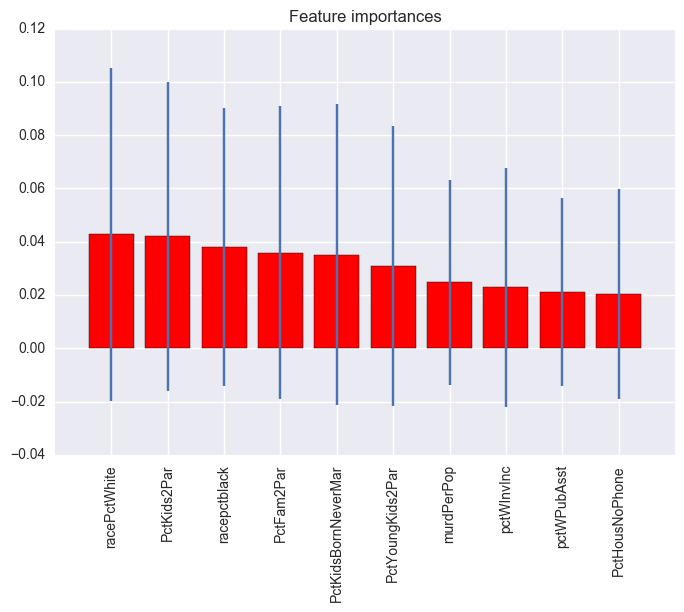

In [39]:
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier
import seaborn as sns

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

#X_arr = feature_matrix_clean
#y_arr = [ (1 if (x > AVG_CRIME) else 0) for x in target_vector1_clean]
forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

#num_attributes = len(X_arr[0])
top_x = 10 # just get top 10
for f in range(top_x):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], df2.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(top_x), importances[indices[:top_x]],
       color="r", yerr=std[indices[:top_x]], align="center")
plt.xticks(range(top_x), [df2.columns[indices[i]] for i in range(top_x)], rotation = 90)
plt.xlim([-1, top_x])
plt.show()

Also with random forests, we can look at variable importance. The plot above shows the top 10 most important variables. We get that racePctWhite is the most important, so the percentage of caucasians in the city seems to be the most important factor. pctKids2Par is the percentage of kids in family housing with two parents, next is 
racepctblack (percentage of population that is african american). Next is PctFam2Par, percentage of families (with kids) that are headed by two parents. The fifth most important variables is PctKidsBornNeverMar, percentage of kids born to never married. Looking at the graph and numbers though, it seems that the importance values are actually all quite close and the most important is not so far from the second most important variable.


In [40]:
# random forest w/ CV
predicted_rf_cv = cross_validation.cross_val_predict(RandomForestClassifier(n_estimators=20), X, y, cv=10)
print(metrics.accuracy_score(y, predicted_rf_cv))
print(metrics.classification_report(y, predicted_rf_cv))

0.856569709127
             precision    recall  f1-score   support

      False       0.88      0.92      0.90      1362
       True       0.81      0.72      0.76       632

avg / total       0.85      0.86      0.85      1994



In [41]:
cm1b = confusion_matrix(y, predicted_rf_cv)
statistical_measures(cm1b)

{'ACC': array([ 0.85656971,  0.85656971]),
 'FDR': array([ 0.12430168,  0.19217082]),
 'FNR': array([ 0.07929515,  0.28164557]),
 'FPR': array([ 0.28164557,  0.07929515]),
 'NPV': array([ 0.80782918,  0.87569832]),
 'PPV': array([ 0.87569832,  0.80782918]),
 'TNR': array([ 0.71835443,  0.92070485]),
 'TPR': array([ 0.92070485,  0.71835443])}

In [ ]:
sum(y) / len(y)

## 3.4 Using the top 10 most important variables

From the variable importance plots, we try just using the top 10 variables to see how good of predictions we can get. Below, we use random forest and logistic regression and get similar results, the accuracy is around 0.85. This is worse than using logistic regression on all of the variables, but virtually the same as using random forest with all of the variables. This result makes sense since we are taking the top variables from generated by fitting a random forest.

In [83]:
df_sub = df2[['racePctWhite','PctKids2Par','racepctblack','PctFam2Par', 
              'PctKidsBornNeverMar', 'PctYoungKids2Par', 'murdPerPop',
             'pctWInvInc','pctWInvInc','pctWPubAsst', 'PctHousNoPhone']]
df_sub.head(2)

,racePctWhite,PctKids2Par,racepctblack,PctFam2Par,PctKidsBornNeverMar,PctYoungKids2Par,murdPerPop,pctWInvInc,pctWInvInc,pctWPubAsst,PctHousNoPhone
0,91.78,90.17,1.37,91.43,0.36,95.78,0.0,70.20,70.20,1.03,0.00
1,95.57,85.33,0.80,86.91,0.24,96.82,0.0,64.11,64.11,2.75,0.31


In [84]:
X_sub = df_sub[df.ViolentCrimesPerPop != '?'] # didn't get rid of '?' in the y (ViolentCrimesPerPop) yet
y_sub = df.ViolentCrimesPerPop[df.ViolentCrimesPerPop != '?']
y_sub = y # make the y 0 or 1

predicted_rf_cv_sub = cross_validation.cross_val_predict(RandomForestClassifier(n_estimators=20), X_sub, y_sub, cv=10)
cm_sub = confusion_matrix(y_sub, predicted_rf_cv_sub)
statistical_measures(cm_sub)

{'ACC': array([ 0.85155466,  0.85155466]),
 'FDR': array([ 0.12411848,  0.20833333]),
 'FNR': array([ 0.08810573,  0.27848101]),
 'FPR': array([ 0.27848101,  0.08810573]),
 'NPV': array([ 0.79166667,  0.87588152]),
 'PPV': array([ 0.87588152,  0.79166667]),
 'TNR': array([ 0.72151899,  0.91189427]),
 'TPR': array([ 0.91189427,  0.72151899])}

In [85]:
predicted_rf_cv_sub = cross_validation.cross_val_predict(RandomForestClassifier(n_estimators=20), X_sub, y_sub, cv=10)
cm_sub = confusion_matrix(y_sub, predicted_rf_cv_sub)
statistical_measures(cm_sub)

{'ACC': array([ 0.84603811,  0.84603811]),
 'FDR': array([ 0.13137666,  0.21136767]),
 'FNR': array([ 0.08737151,  0.29746835]),
 'FPR': array([ 0.29746835,  0.08737151]),
 'NPV': array([ 0.78863233,  0.86862334]),
 'PPV': array([ 0.86862334,  0.78863233]),
 'TNR': array([ 0.70253165,  0.91262849]),
 'TPR': array([ 0.91262849,  0.70253165])}

## 4 Trying Subsets of the Variables
In all of section 3, we used all of the variables (except for the variables that contained mostly NAs). Now we are interested in looking at different subsets, such as variables relating to education, race, etc. to see if we can make accurate predictions with less variables.

### 4.1 Education
First we try education related variables, PctLess9thGrade (the percentage of people 25 and over with less than a 9th grade education), PctNotHsGrad (percentage of people 25 and over that are not high school graduates), and PctBSorMore (percentage of people 25 and over with a bachelors degree of higher education). Below, we will find that just using education gives a much lower accuracy than what we have seen from other models that use more attributes. We used random forest and logistic regression, both give similar results, logistic regression is slightly better. We'll analyze the slightly better model (logistic regression), the accuracy is around 0.75 (error is around 0.25, quite close to the base rate of 0.31). The false negative rate is also quite high at 0.54, that is also concerning to see.

In [46]:
df_ed = df2[['PctLess9thGrade','PctNotHSGrad','PctBSorMore']]
df_ed.head(5)

,PctLess9thGrade,PctNotHSGrad,PctBSorMore
0,5.81,9.90,48.18
1,5.61,13.72,29.89
2,2.80,9.09,30.13
3,11.05,33.68,10.81
4,12.15,23.06,25.28


In [54]:
X_ed = df_ed[df.ViolentCrimesPerPop != '?'] # didn't get rid of '?' in the y (ViolentCrimesPerPop) yet
y_ed = df.ViolentCrimesPerPop[df.ViolentCrimesPerPop != '?']
y_ed = y # make the y 0 or 1
X_ed.shape, y_ed.shape

((1994, 3), (1994,))

In [62]:
predicted_rf_cv_ed = cross_validation.cross_val_predict(RandomForestClassifier(n_estimators=20), X_ed, y_ed, cv=10)
cm_ed = confusion_matrix(y_ed, predicted_rf_cv_ed)
statistical_measures(cm_ed)

{'ACC': array([ 0.72768305,  0.72768305]),
 'FDR': array([ 0.22199593,  0.41458733]),
 'FNR': array([ 0.15859031,  0.51740506]),
 'FPR': array([ 0.51740506,  0.15859031]),
 'NPV': array([ 0.58541267,  0.77800407]),
 'PPV': array([ 0.77800407,  0.58541267]),
 'TNR': array([ 0.48259494,  0.84140969]),
 'TPR': array([ 0.84140969,  0.48259494])}

In [63]:
predicted_ed = cross_validation.cross_val_predict(linear_model.LogisticRegression(penalty='l2'), X_ed, y_ed, cv=10)
cm_ed2 = confusion_matrix(y_ed, predicted_ed)
statistical_measures(cm_ed2)

{'ACC': array([ 0.74974925,  0.74974925]),
 'FDR': array([ 0.22215068,  0.34920635]),
 'FNR': array([ 0.11306902,  0.54588608]),
 'FPR': array([ 0.54588608,  0.11306902]),
 'NPV': array([ 0.65079365,  0.77784932]),
 'PPV': array([ 0.77784932,  0.65079365]),
 'TNR': array([ 0.45411392,  0.88693098]),
 'TPR': array([ 0.88693098,  0.45411392])}

### 4.2 Family Information

We next explore information about families and how this might affect crime rates. We will look a variables such as the percentage of male and females who are diveroced or never married, the percent of familes with kids (under 4, teenagers) and kids who do not have parents who are married.

In [58]:
df_fam = df2.ix[:,37:50]
df_fam.head(5)

,MalePctDivorce,MalePctNevMarr,FemalePctDiv,TotalPctDiv,PersPerFam,PctFam2Par,PctKids2Par,PctYoungKids2Par,PctTeen2Par,PctWorkMomYoungKids,PctWorkMom,NumKidsBornNeverMar,PctKidsBornNeverMar
0,3.67,26.38,5.22,4.47,3.22,91.43,90.17,95.78,95.81,44.56,58.88,31,0.36
1,4.23,27.99,6.45,5.42,3.11,86.91,85.33,96.82,86.46,51.14,62.43,43,0.24
2,10.10,25.78,14.76,12.55,2.95,78.54,78.85,92.37,75.72,66.08,74.19,164,0.88
3,10.98,28.15,14.47,12.91,2.98,64.02,62.36,65.38,67.43,59.59,70.27,561,3.84
4,7.51,50.66,11.64,9.73,2.98,58.59,55.20,66.51,79.17,61.22,68.94,402,4.70


In [70]:
X_fam = df_fam[df.ViolentCrimesPerPop != '?'] # didn't get rid of '?' in the y (ViolentCrimesPerPop) yet
y_fam = df.ViolentCrimesPerPop[df.ViolentCrimesPerPop != '?']
y_fam = y

In [71]:
predicted_rf_cv_fam = cross_validation.cross_val_predict(RandomForestClassifier(n_estimators=20), X_fam, y_fam, cv=10)
cm_fam = confusion_matrix(y_fam, predicted_rf_cv_fam)
statistical_measures(cm_fam)

{'ACC': array([ 0.84503511,  0.84503511]),
 'FDR': array([ 0.13664596,  0.20366972]),
 'FNR': array([ 0.0814978 ,  0.31329114]),
 'FPR': array([ 0.31329114,  0.0814978 ]),
 'NPV': array([ 0.79633028,  0.86335404]),
 'PPV': array([ 0.86335404,  0.79633028]),
 'TNR': array([ 0.68670886,  0.9185022 ]),
 'TPR': array([ 0.9185022 ,  0.68670886])}

In [72]:
predicted_fam = cross_validation.cross_val_predict(linear_model.LogisticRegression(penalty='l2'), X_fam, y_fam, cv=10)
cm_fam2 = confusion_matrix(y_fam, predicted_fam)
statistical_measures(cm_fam2)

{'ACC': array([ 0.8550652,  0.8550652]),
 'FDR': array([ 0.1276891 ,  0.18987342]),
 'FNR': array([ 0.07709251,  0.29113924]),
 'FPR': array([ 0.29113924,  0.07709251]),
 'NPV': array([ 0.81012658,  0.8723109 ]),
 'PPV': array([ 0.8723109 ,  0.81012658]),
 'TNR': array([ 0.70886076,  0.92290749]),
 'TPR': array([ 0.92290749,  0.70886076])}

Using attributes related to family, we get better predictions than when using education variables. But we still see lower accuracies compared to when we used more attributes. Again, using logistic regression and random forests give similar results. Here, we get an error rate of around 0.145, much better than in section 4.1. Furthmore, an error rate around 0.145 is actually quite close to when we used a random forest on all the attributes (except the ones with mostly NAs) back in section 3.3. This may mean that family information can give indications of whether there will be more crime or not in a city.

### 4.3 Household
Next, we will look at variables related to households. For example, we will use percentage of the population with large households (more than 9 people living in the same house), how many vacant houses there, etc. 

In [73]:
df_h = df2.ix[:,61:92]
df_h.head(2)

,PctLargHouseFam,PctLargHouseOccup,PersPerOccupHous,PersPerOwnOccHous,PersPerRentOccHous,PctPersOwnOccup,PctPersDenseHous,PctHousLess3BR,MedNumBR,HousVacant,...,RentLowQ,RentMedian,RentHighQ,RentQrange,MedRent,MedRentPctHousInc,MedOwnCostPctInc,MedOwnCostPctIncNoMtg,NumInShelters,NumStreet
0,4.81,4.17,2.99,3.00,2.84,91.46,0.39,11.06,3,64,...,685,1001,1001,316,1001,23.8,21.1,14.0,11,0
1,4.25,3.34,2.70,2.83,1.96,89.03,1.01,23.60,3,240,...,467,560,672,205,627,27.6,20.7,12.5,0,0


In [74]:
X_h = df_h[df.ViolentCrimesPerPop != '?'] # didn't get rid of '?' in the y (ViolentCrimesPerPop) yet
y_h = df.ViolentCrimesPerPop[df.ViolentCrimesPerPop != '?']
y_h = y

predicted_rf_cv_h = cross_validation.cross_val_predict(RandomForestClassifier(n_estimators=20), X_h, y_h, cv=10)
cm_h = confusion_matrix(y_h, predicted_rf_cv_h)
statistical_measures(cm_h)

{'ACC': array([ 0.83500502,  0.83500502]),
 'FDR': array([ 0.14354727,  0.22201835]),
 'FNR': array([ 0.08883994,  0.32911392]),
 'FPR': array([ 0.32911392,  0.08883994]),
 'NPV': array([ 0.77798165,  0.85645273]),
 'PPV': array([ 0.85645273,  0.77798165]),
 'TNR': array([ 0.67088608,  0.91116006]),
 'TPR': array([ 0.91116006,  0.67088608])}

In [75]:
predicted_h = cross_validation.cross_val_predict(linear_model.LogisticRegression(penalty='l2'), X_h, y_h, cv=10)
cm_h2 = confusion_matrix(y_h, predicted_h)
statistical_measures(cm_h2)

{'ACC': array([ 0.81895687,  0.81895687]),
 'FDR': array([ 0.16476892,  0.22954092]),
 'FNR': array([ 0.08443465,  0.38924051]),
 'FPR': array([ 0.38924051,  0.08443465]),
 'NPV': array([ 0.77045908,  0.83523108]),
 'PPV': array([ 0.83523108,  0.77045908]),
 'TNR': array([ 0.61075949,  0.91556535]),
 'TPR': array([ 0.91556535,  0.61075949])}

### 4.4 Income
Next we look at income information like the median income in the city, percent of the population with a wage, percent of households that are self employed, percent of people who are unemployed, etc.

In [76]:
df_in = df2[[ 'medIncome', 'pctWWage','pctWFarmSelf','pctWInvInc','pctWSocSec','pctWPubAsst','pctWRetire',
           'medFamInc','perCapInc','NumUnderPov','PctPopUnderPov','PctUnemployed','PctEmploy']]
df_in.head(2)

,medIncome,pctWWage,pctWFarmSelf,pctWInvInc,pctWSocSec,pctWPubAsst,pctWRetire,medFamInc,perCapInc,NumUnderPov,PctPopUnderPov,PctUnemployed,PctEmploy
0,75122,89.24,1.55,70.20,23.62,1.03,18.39,79584,29711,227,1.96,2.70,64.55
1,47917,78.99,1.11,64.11,35.50,2.75,22.85,55323,20148,885,3.98,2.43,61.96


In [77]:
X_in = df_in[df.ViolentCrimesPerPop != '?'] # didn't get rid of '?' in the y (ViolentCrimesPerPop) yet
y_in = df.ViolentCrimesPerPop[df.ViolentCrimesPerPop != '?']
y_in = y

predicted_rf_cv_in = cross_validation.cross_val_predict(RandomForestClassifier(n_estimators=20), X_in, y_in, cv=10)
cm_in = confusion_matrix(y_in, predicted_rf_cv_in)
statistical_measures(cm_in)

{'ACC': array([ 0.83049147,  0.83049147]),
 'FDR': array([ 0.14786795,  0.22777778]),
 'FNR': array([ 0.09030837,  0.34018987]),
 'FPR': array([ 0.34018987,  0.09030837]),
 'NPV': array([ 0.77222222,  0.85213205]),
 'PPV': array([ 0.85213205,  0.77222222]),
 'TNR': array([ 0.65981013,  0.90969163]),
 'TPR': array([ 0.90969163,  0.65981013])}

In [78]:
predicted_in = cross_validation.cross_val_predict(linear_model.LogisticRegression(penalty='l2'), X_in, y_in, cv=10)
cm_in2 = confusion_matrix(y_in, predicted_in)
statistical_measures(cm_in2)

{'ACC': array([ 0.82998997,  0.82998997]),
 'FDR': array([ 0.14893617,  0.22718808]),
 'FNR': array([ 0.08957416,  0.34335443]),
 'FPR': array([ 0.34335443,  0.08957416]),
 'NPV': array([ 0.77281192,  0.85106383]),
 'PPV': array([ 0.85106383,  0.77281192]),
 'TNR': array([ 0.65664557,  0.91042584]),
 'TPR': array([ 0.91042584,  0.65664557])}

### 4.5 Race/Ethnicity
From the random forest in section 3.3, we saw that race seemed to contribute the most. Now we will look at the variables related to race and see if we can make accurate predictions from them.

In [80]:
df_ra = df2[['racePctWhite','racePctAsian','racepctblack','racePctHisp']]
df_ra.head(2)

,racePctWhite,racePctAsian,racepctblack,racePctHisp
0,91.78,6.50,1.37,1.88
1,95.57,3.44,0.80,0.85


In [81]:
X_ra = df_ra[df.ViolentCrimesPerPop != '?'] # didn't get rid of '?' in the y (ViolentCrimesPerPop) yet
y_ra = df.ViolentCrimesPerPop[df.ViolentCrimesPerPop != '?']
y_ra = y

predicted_rf_cv_ra = cross_validation.cross_val_predict(RandomForestClassifier(n_estimators=20), X_ra, y_ra, cv=10)
cm_ra = confusion_matrix(y_ra, predicted_rf_cv_ra)
statistical_measures(cm_ra)

{'ACC': array([ 0.8109328,  0.8109328]),
 'FDR': array([ 0.15679443,  0.27191413]),
 'FNR': array([ 0.11160059,  0.35601266]),
 'FPR': array([ 0.35601266,  0.11160059]),
 'NPV': array([ 0.72808587,  0.84320557]),
 'PPV': array([ 0.84320557,  0.72808587]),
 'TNR': array([ 0.64398734,  0.88839941]),
 'TPR': array([ 0.88839941,  0.64398734])}

In [82]:
predicted_ra = cross_validation.cross_val_predict(linear_model.LogisticRegression(penalty='l2'), X_ra, y_ra, cv=10)
cm_ra2 = confusion_matrix(y_ra, predicted_ra)
statistical_measures(cm_ra2)

{'ACC': array([ 0.82347041,  0.82347041]),
 'FDR': array([ 0.16467463,  0.21311475]),
 'FNR': array([ 0.0763583 ,  0.39240506]),
 'FPR': array([ 0.39240506,  0.0763583 ]),
 'NPV': array([ 0.78688525,  0.83532537]),
 'PPV': array([ 0.83532537,  0.78688525]),
 'TNR': array([ 0.60759494,  0.9236417 ]),
 'TPR': array([ 0.9236417 ,  0.60759494])}

Looking at all of the subsets, family information, household information, income, and race information all perform about the same. However, just using education gives the worst and just family information does the best (for the subsets we tested). Looking at these subsets gives us good insight and tells us that we could make decent predictions with just these subsets. 

## 5 Conclusions
It was interesting to find that if we used all of the attributes (except for the ones with mostly NAs), most of the important variables were related to race. Several of the important variables were also relevant to family life but it is unsurprising that important variables are mostly related as they influence each other. However, it was surprising that none of the influential variables were related to income, for example there did not seem to variables about housing, employment or police that was "important." However, we note that our model used many attributes and this in practice is not very practical because a city would need to survey a lot of information in order for our model to be useful. In the case of using all of the attributes, logistic regression seemed to be the best because it had a very low error rate and very low false negative rates. 

Then when we looked at just using specific varibles like just race or household, we got worse results but still OK. In the real world, perhaps we would not have all of the information we had in this data and instead only had information about the familes. From section 4.2, we saw that we could still get an accuracy of around 0.85. However, just using education information did not seem to give that great of predictions, accuracy of around 0.72. Nevertheless, our analysis from section 4 tells us that we could use subsets and get OK results because over 100 attributes is a lot, so using just 5 to 10 would probably be more feasible. 

Our models could be used by mayors if they want to see what factors in their city is contributing most to crime rates. For example, if it appeared that families with mostly unemployed members was an important variable in determining crime rates, the mayor could initialize more plans to create jobs. However, variables like the one we found to be the most important, percentage of Caucasians in the populaton, would not be very helpful to a mayor as one cannot control such things. Additionally it's important to realize that factors like percentage of a certain type of race that appeared to be one of the important factors may not actually be the cause of the crime rates. Also families may be interested in this model because if they want to move to another city, it may be important to them to see if a city has higher than average crime rates.


## 6 Next Steps
We could find a more recent dataset because the one we are using is from 1995 and may not be as relevant. However, perhaps the data is still OK since crime is not extremely volatile, it does not change much throughout, as opposed to something relating to technology. Our data set also was not very complete because it was missing a lot of the police information and perhaps that information could have been useful. We also could look for connections and similarities within subsets of the data.

